In [1]:
# 1 Download the corpus and split it into training and testing sets to build a data frame.
import urllib.request
import zipfile
import os
from nltk.parse.dependencygraph import DependencyGraph

# Download the dependency treebank corpus
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
filename = "dependency_treebank.zip"
urllib.request.urlretrieve(url, filename)

# Extract the files
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

# Define the boundaries for dataset splitting
train_size = 100
val_size = 50

# Create directories for saving the datasets
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)
os.makedirs("data/test", exist_ok=True)

# Iterate over each file and split it into the corresponding dataset based on the boundaries
for i, file in enumerate(sorted(os.listdir("dependency_treebank"))):
    with open(os.path.join("dependency_treebank", file), 'r') as f:
        # Load each file using the DependencyGraph class
        dg = DependencyGraph(f.read())
        # Convert the dependency tree to a CoNLL-formatted string
        conll_str = dg.to_conll(4)  # Use index 4 for word and index 6 for POS tag
        # Remove the third column containing the numerical values
        conll_str = '\n'.join(['\t'.join(line.split('\t')[:2]) for line in conll_str.split('\n')])
        if i < train_size:
            with open(os.path.join("data/train", file), 'w') as f_train:
                f_train.write(conll_str)
        elif i < train_size + val_size:
            with open(os.path.join("data/val", file), 'w') as f_val:
                f_val.write(conll_str)
        else:
            with open(os.path.join("data/test", file), 'w') as f_test:
                f_test.write(conll_str)



In [2]:
#2 Create a data frame
import pandas as pd

# Create empty lists to store the data
train_data = []
val_data = []
test_data = []

# Iterate over each file and split it into the corresponding dataset based on the boundaries
for i, file in enumerate(sorted(os.listdir("dependency_treebank"))):
    with open(os.path.join("dependency_treebank", file), 'r') as f:
        # Load each file using the DependencyGraph class
        dg = DependencyGraph(f.read())
        # Convert the dependency tree to a CoNLL-formatted string
        conll_str = dg.to_conll(4)  # Use index 4 for word and index 6 for POS tag
        # Split CoNLL-formatted string into lines
        conll_lines = conll_str.split('\n')
        # Extract words and POS tags and store them in the data lists
        if i < train_size:
            train_data.extend([line.split('\t')[:2] for line in conll_lines if line])
        elif i < train_size + val_size:
            val_data.extend([line.split('\t')[:2] for line in conll_lines if line])
        else:
            test_data.extend([line.split('\t')[:2] for line in conll_lines if line])

# Create dataframes from the lists
train_df = pd.DataFrame(train_data, columns=['Word', 'POS'])
val_df = pd.DataFrame(val_data, columns=['Word', 'POS'])
test_df = pd.DataFrame(test_data, columns=['Word', 'POS'])

print(train_df.head(10))


     Word  POS
0  Pierre  NNP
1  Vinken  NNP
2       ,    ,
3      61   CD
4   years  NNS
5     old   JJ
6       ,    ,
7    will   MD
8    join   VB
9     the   DT


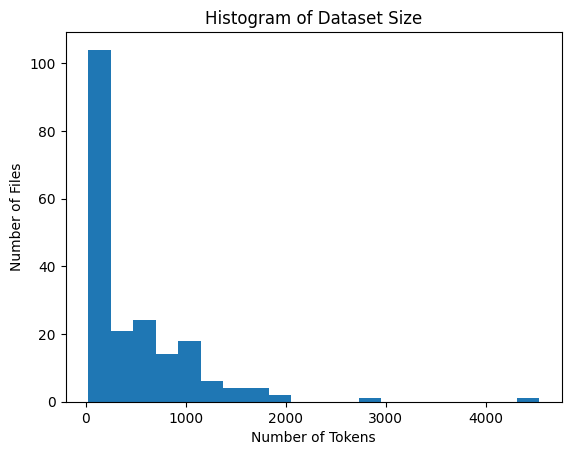

In [3]:
#3 Count and plot the distribution of the number of words in each file in a dependency tree bank.
import os
import matplotlib.pyplot as plt

data_dir = "dependency_treebank"

# create a list to store the number of tokens in each file
num_tokens = []

# iterate over each file in the corpus directory and count the number of tokens in each file
for file in os.listdir(data_dir):
    with open(os.path.join(data_dir, file), 'r') as f:
        # count the number of non-empty lines in the file
        count = sum([1 for line in f if line.strip()])
        num_tokens.append(count)

# plot a histogram of the number of tokens per file
plt.hist(num_tokens, bins=20)
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Files")
plt.title("Histogram of Dataset Size")
plt.show()



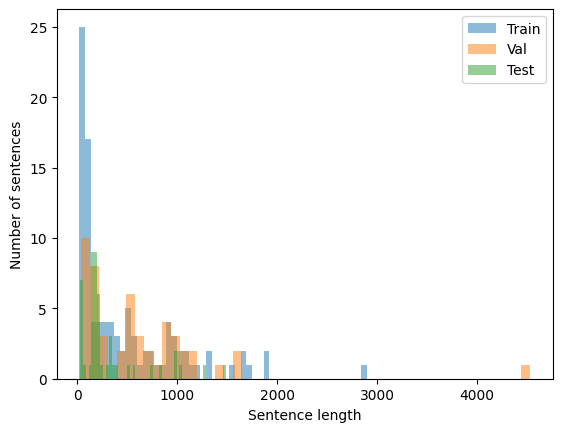

In [4]:
#4 Draw a histogram of the sentence length distribution
import os
import matplotlib.pyplot as plt

# Define the directories containing the datasets
train_dir = "data/train"
val_dir = "data/val"
test_dir = "data/test"

# Define a function to get the sentence lengths from a directory of CoNLL-formatted files
def get_sentence_lengths(directory):
    sentence_lengths = []
    for file in os.listdir(directory):
        with open(os.path.join(directory, file), 'r') as f:
            sentences = f.read().strip().split('\n\n')
            for sentence in sentences:
                words = sentence.split('\n')
                sentence_length = len(words)
                sentence_lengths.append(sentence_length)
    return sentence_lengths

# Get the sentence lengths for each dataset
train_lengths = get_sentence_lengths(train_dir)
val_lengths = get_sentence_lengths(val_dir)
test_lengths = get_sentence_lengths(test_dir)

# Plot the sentence length distributions
plt.hist(train_lengths, bins=50, alpha=0.5, label="Train")
plt.hist(val_lengths, bins=50, alpha=0.5, label="Val")
plt.hist(test_lengths, bins=50, alpha=0.5, label="Test")
plt.xlabel("Sentence length")
plt.ylabel("Number of sentences")
plt.legend()
plt.show()


In [5]:
#5 Embedding words using GloVe embedding
import requests
import zipfile
import os
import numpy as np

# Download the GloVe embeddings
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
filename = 'glove.6B.zip'

# Download the file using requests
response = requests.get(url, stream=True)
with open(filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

# Extract the files
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

# Define the path to the glove file
glove_file = 'glove.6B.50d.txt'  # 50维的GloVe词向量

# Read the GloVe embed file
def read_glove_vectors(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    word_to_vec = {}
    for line in lines:
        line = line.strip()
        cols = line.split()
        word = cols[0]
        vec = np.array(cols[1:], dtype='float32')
        word_to_vec[word] = vec
    return word_to_vec

# Download GloVe word vectors and read them using the modified code
embedding_matrix = read_glove_vectors(glove_file)
# Get the word vector for a specific word like "apple"
word_to_vec = read_glove_vectors(glove_file)

word = "bologna"
if word in word_to_vec:
    embedding = word_to_vec[word]
    print(embedding)
else:
    print(f"Word '{word}' not found in the GloVe embeddings.")


[ 1.1444    -0.81117   -1.4844    -0.4381     0.074385  -0.61125
  0.025821  -0.33074   -1.4416     0.54004    0.12569   -0.62678
 -0.17099   -0.67438    0.062094  -1.4678    -0.6109     0.25955
 -0.89278    0.95611   -0.46918   -0.42878   -0.24556    0.76318
 -0.44466   -0.42965    1.1653     0.44225   -0.65406   -0.76654
  1.0743     0.93283   -0.16853    0.12356   -0.30396    0.39219
  0.2029     1.8895     0.95429   -0.13466    0.77791   -0.0038449
  0.20357   -0.62053    0.045134   1.4153     0.4148    -0.055174
  1.0996    -0.29872  ]


In [6]:
#6-1 Compute embeddings for terms in the training split vocabulary V1 (OOV1)

# Create a vocabulary from the training data
vocab = set()
for sentence in train_data:
    words = sentence  # Each sentence is already a list of words
    vocab.update(words)

# Create word to index mapping
word_to_index = {word: index for index, word in enumerate(vocab)}

# Convert the embedding matrix to a dictionary
embedding_dict = {word: embedding_matrix[index] for word, index in word_to_index.items() if word in set(embedding)}

# Generate the embedding matrix
embedding_dim = 50  # Dimension of GloVe vectors
num_words = len(vocab)
embedding_matrix = np.zeros((num_words, embedding_dim))
for index, word in enumerate(word_to_index.keys()):
    if word in embedding_dict:
        embedding_matrix[index] = embedding_dict[word]


In [7]:
#6-2 Add embeddings to the vocabulary so that we get vocabulary V2=V1+OOV1

# Create a set of all words in V1
vocab_v1 = set(vocab)

# Add OOV words to V2
oov_words = set()
for sentence in train_data + val_data + test_data:
    words = sentence  # Tokenize the sentence
    oov_words.update(word for word in words if word not in vocab_v1)

# Create word to index mapping for V2
word_to_index_v2 = {word: index for index, word in enumerate(vocab_v1)}

# Add OOV words to V2 and assign indices
for oov_word in oov_words:
    word_to_index_v2[oov_word] = len(word_to_index_v2)

# Generate the embedding matrix for V2
num_words_v2 = len(word_to_index_v2)
embedding_matrix_v2 = np.zeros((num_words_v2, embedding_dim))
for word, index in word_to_index_v2.items():
    if word in embedding_dict:
        embedding_matrix_v2[index] = embedding_dict[word]
    else:
        # Initialize OOV word embeddings randomly (you can choose any strategy)
        embedding_matrix_v2[index] = np.random.uniform(-0.25, 0.25, embedding_dim)


In [8]:
#6-3 Add embeddings to the vocabulary so that we get vocabulary V2=V1+OOV1

# Create a set of all words in the validation set (V2)
vocab_v2 = set()
for sentence in val_data:
    words = sentence  # Tokenize the sentence
    vocab_v2.update(words)

# Identify OOV2 words (words in vocab_v2 but not in vocab_v1)
oov2_words = [word for word in vocab_v2 if word not in vocab_v1]

# Create word to index mapping for V2
word_to_index_v2 = {word: index for index, word in enumerate(vocab_v1)}

# Add OOV2 words to V2 and assign indices
for oov2_word in oov2_words:
    word_to_index_v2[oov2_word] = len(word_to_index_v2)

# Generate the embedding matrix for V2
num_words_v2 = len(word_to_index_v2)
embedding_matrix_v2 = np.zeros((num_words_v2, embedding_dim))
for word, index in word_to_index_v2.items():
    if word in embedding_dict:
        embedding_matrix_v2[index] = embedding_dict[word]
    else:
        # Initialize OOV word embeddings randomly (you can choose any strategy)
        embedding_matrix_v2[index] = np.random.uniform(-0.25, 0.25, embedding_dim)


In [9]:
#6-4 Add embeddings to the vocabulary so that we get vocabulary V3=V1+OOV1+OOV2

# Create a set of all words in the training, validation, and test sets (V3)
vocab_v3 = set()
for sentence in train_data + val_data + test_data:
    words = sentence  # Tokenize the sentence
    vocab_v3.update(words)

# Identify OOV3 words (words in vocab_v3 but not in vocab_v2)
oov3_words = [word for word in vocab_v3 if word not in vocab_v2]

# Create word to index mapping for V3
word_to_index_v3 = {word: index for index, word in enumerate(word_to_index_v2)}

# Create embedding matrix for V3
num_words_v3 = len(word_to_index_v3)
embedding_matrix_v3 = np.zeros((num_words_v3, embedding_dim))
for word, index in word_to_index_v3.items():
    if word in embedding_dict:
        embedding_matrix_v3[index] = embedding_dict[word]
    elif word in oov3_words:
        # Initialize OOV word embeddings randomly (you can choose any strategy)
        embedding_matrix_v3[index] = np.random.uniform(-0.25, 0.25, embedding_dim)


In [10]:
#6-5 Computing the embedding of the term OOV3 for the test split

# Create a set of all words in the test set (V3)
vocab_test = set()
for sentence in test_data:
    words = sentence # Tokenize the sentence
    vocab_test.update(words)

# Identify OOV3 words (words in vocab_test but not in vocab_v3)
oov3_words_test = [word for word in vocab_test if word not in vocab_v3]

# Create word to index mapping for V3
word_to_index_test = {word: index for index, word in enumerate(word_to_index_v3)}

# Create embedding matrix for testing OOV3 words
num_words_test = len(word_to_index_test)
embedding_matrix_test = np.zeros((num_words_test, embedding_dim))
for word, index in word_to_index_test.items():
    if word in embedding_dict:
        embedding_matrix_test[index] = embedding_dict[word]
    elif word in oov3_words_test:
        # Initialize OOV word embeddings randomly (you can choose any strategy)
        embedding_matrix_test[index] = np.random.uniform(-0.25, 0.25, embedding_dim)


In [11]:
#6-6 Add embeddings to the vocabulary so that we get vocabulary V4=V1+OOV1+OOV2+OOV3

# Create a set of OOV1 words (words in V2 but not in V1)
oov1_words = [word for word in vocab_v2 if word not in vocab_v1]

# Create a set of OOV2 words (words in V3 but not in V2)
oov2_words = [word for word in vocab_v3 if word not in vocab_v2]

# Create a set of OOV3 words (words in test set but not in V3)
oov3_words = [word for word in vocab_test if word not in vocab_v3]

# Create a set of all words in V1, OOV1, OOV2, and OOV3
vocab_v4 = set(vocab_v1).union(set(oov1_words), set(oov2_words), set(oov3_words))

# Create word to index mapping for V4
word_to_index_v4 = {word: index for index, word in enumerate(word_to_index_v3)}

# Add OOV4 words to V4 and assign indices
for oov4_word in vocab_v4:
    if oov4_word not in word_to_index_v4:
        word_to_index_v4[oov4_word] = len(word_to_index_v4)

# Generate the embedding matrix for V4
num_words_v4 = len(word_to_index_v4)
embedding_matrix_v4 = np.zeros((num_words_v4, embedding_dim))
for word, index in word_to_index_v4.items():
    if word in embedding_dict:
        embedding_matrix_v4[index] = embedding_dict[word]
    else:
        # Initialize OOV word embeddings randomly (you can choose any strategy)
        embedding_matrix_v4[index] = np.random.uniform(-0.25, 0.25, embedding_dim)


In [12]:
#7 Prepare the model
finally train the mode
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define hyperparameters
hidden_size = 100
num_classes = 10
learning_rate = 0.001
batch_size = 32
num_epochs = 10

# Convert embedding_matrix to PyTorch tensor
embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float)


# Create a label to index mapping
label_index_mapping = {}
for idx, label in enumerate(sorted(set(train_df['POS']))):
    label_index_mapping[label] = idx

# Convert words in text data to corresponding indices using word_to_index_v4
train_data_indices = [[word_to_index_v4[word] for word in sentence.split()] for sentence in train_df['Word']]
train_labels = [label_index_mapping[label] for label in train_df['POS']]

# Find the maximum sentence length in train_data_indices
max_sentence_length = max(len(sentence) for sentence in train_data_indices)

# Pad sentences to the maximum length
padded_train_data_indices = [sentence + [0] * (max_sentence_length - len(sentence)) for sentence in train_data_indices]

# Convert to PyTorch tensor
train_data_indices_tensor = torch.tensor(padded_train_data_indices)

# Create DataLoader for training data
train_dataset = TensorDataset(train_data_indices_tensor, torch.tensor(train_labels))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



# Check missing labels in validation data
missing_labels = set(val_df['POS']) - set(label_index_mapping.keys())

# Add missing labels to label_index_mapping with appropriate indices
for missing_label in missing_labels:
    label_index_mapping[missing_label] = len(label_index_mapping)

# Convert words in validation data to corresponding indices using word_to_index_v4
val_data_indices = [[word_to_index_v4[word] for word in sentence.split()] for sentence in val_df['Word']]
val_labels = [label_index_mapping[label] for label in val_df['POS']]

# Find the maximum sentence length in validation data_indices
max_val_sentence_length = max(len(sentence) for sentence in val_data_indices)

# Pad validation sentences to the maximum length
padded_val_data_indices = [sentence + [0] * (max_val_sentence_length - len(sentence)) for sentence in val_data_indices]

# Convert to PyTorch tensor
val_data_indices_tensor = torch.tensor(padded_val_data_indices)

# Create DataLoader for validation data
val_dataset = TensorDataset(val_data_indices_tensor, torch.tensor(val_labels))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for validation






#7 Create a baseline model using a simple neural architecture
# Baseline: Two-layer architecture: a bidirectional LSTM layer and a dense/fully connected layer on top.
#Architecture: Experiment with GRUs instead of LSTMs, add extra LSTM layers, and add extra dense layers.

import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, embedding_matrix_v4, hidden_size, num_classes):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_v4, padding_idx=0, freeze=True)
        self.gru = nn.GRU(input_size=embedding_matrix_v4.shape[1], hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc1(output[:, -1, :])
        output = self.relu(output)
        output = self.fc2(output)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_matrix_v4_tensor = torch.tensor(embedding_matrix_v4, dtype=torch.float).to(device)
model_GRU = GRUModel(embedding_matrix_v4_tensor, hidden_size=100, num_classes=10).to(device)

print(model_GRU)




GRUModel(
  (embedding): Embedding(12003, 50, padding_idx=0)
  (gru): GRU(50, 100, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [13]:
#8 Based on the extension and improvement of the baseline model, by adding layers and parameters, different model configurations can be tried to achieve better performance.
import torch
import torch.nn as nn
import torch.optim as optim

class ModifiedModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_classes):
        super(ModifiedModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix_v4))
        self.gru = nn.GRU(input_size=embedding_matrix_v4.shape[1], hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = output[:, -1, :]
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_modified = ModifiedModel(embedding_matrix_v4, hidden_size=100, num_classes=10).to(device)

print(model_modified)



ModifiedModel(
  (embedding): Embedding(12003, 50)
  (gru): GRU(50, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [14]:
#9 Define hyperparameters
hidden_size = 100
num_classes = len(label_index_mapping)
learning_rate = 0.001
batch_size = 32
num_epochs = 10

# Create an instance of the ModifiedModel
model = ModifiedModel(embedding_matrix_v4, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Variables to track the best model and its performance
best_val_accuracy = 0.0
best_model_weights = None

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_labels in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            _, val_predicted = torch.max(val_outputs, 1)

            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = val_correct / val_total

    # Check if current model has better validation accuracy than the best one so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict().copy()  # Save the best model weights

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Save the best model weights
torch.save(best_model_weights, "best_model_weights.pth")


Epoch [1/10], Loss: 1.8330, Validation Accuracy: 0.5703
Epoch [2/10], Loss: 1.3032, Validation Accuracy: 0.6200
Epoch [3/10], Loss: 1.1292, Validation Accuracy: 0.6457
Epoch [4/10], Loss: 0.9961, Validation Accuracy: 0.6937
Epoch [5/10], Loss: 0.8751, Validation Accuracy: 0.7261
Epoch [6/10], Loss: 0.7644, Validation Accuracy: 0.7454
Epoch [7/10], Loss: 0.6671, Validation Accuracy: 0.7570
Epoch [8/10], Loss: 0.5891, Validation Accuracy: 0.7706
Epoch [9/10], Loss: 0.5232, Validation Accuracy: 0.7856
Epoch [10/10], Loss: 0.4699, Validation Accuracy: 0.7934


In [26]:
#10 Create two best models
class Model1(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_classes):
        super(Model1, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix_v4))
        self.gru = nn.GRU(input_size=embedding_matrix_v4.shape[1], hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = output[:, -1, :]
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        return output

model1 = Model1(embedding_matrix_v4, hidden_size, num_classes).to(device)


class Model2(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_classes):
        super(Model2, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix_v4))
        self.lstm = nn.GRU(input_size=embedding_matrix_v4.shape[1], hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = output[:, -1, :]
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        return output


model2 = Model2(embedding_matrix_v4, hidden_size, num_classes).to(device)

class Model3(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_classes):
        super(Model3, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix_v4))
        self.lstm = nn.LSTM(input_size=embedding_matrix_v4.shape[1], hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = output[:, -1, :]
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        return output


model3 = Model3(embedding_matrix_v4, hidden_size, num_classes).to(device)

print(model1,model2,model3)


Model1(
  (embedding): Embedding(12003, 50)
  (gru): GRU(50, 100, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=45, bias=True)
) Model2(
  (embedding): Embedding(12003, 50)
  (lstm): GRU(50, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=45, bias=True)
) Model3(
  (embedding): Embedding(12003, 50)
  (lstm): LSTM(50, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=45, bias=True)
)


In [31]:
#11.three different models are trained, namely Model1 and Model2, using a similar training loop structure.
#Each model has its own loss function, optimizer and training/validation loop.

# Define loss function and optimizer for Model1
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

# Variables to track the best model and its performance for Model1
best_val_accuracy1 = 0.0
best_model_weights1 = None

# Training loop for Model1
for epoch in range(num_epochs):
    model1.train()
    total_loss = 0.0
    for batch_inputs, batch_labels in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer1.zero_grad()

        outputs = model1(batch_inputs)
        loss = criterion1(outputs, batch_labels)

        loss.backward()
        optimizer1.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation for Model1
    model1.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model1(val_inputs)
            _, val_predicted = torch.max(val_outputs, 1)

            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = val_correct / val_total

    # Check if current model has better validation accuracy than the best one so far for Model1
    if val_accuracy > best_val_accuracy1:
        best_val_accuracy1 = val_accuracy
        best_model_weights1 = model1.state_dict().copy()  # Save the best model weights for Model1

    print(f"Epoch [{epoch+1}/{num_epochs}] - Model1, Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Save the best model weights for Model1
torch.save(best_model_weights1, "best_model_weights_model1.pth")



# Similar training loop and saving for Model2
# Define loss function and optimizer for Model2
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)

# Variables to track the best model and its performance for Model2
best_val_accuracy2 = 0.0
best_model_weights2 = None

# Training loop for Model2
for epoch in range(num_epochs):
    model2.train()
    total_loss = 0.0
    for batch_inputs, batch_labels in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer2.zero_grad()

        outputs = model2(batch_inputs)
        loss = criterion2(outputs, batch_labels)

        loss.backward()
        optimizer2.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation for Model2
    model2.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model2(val_inputs)
            _, val_predicted = torch.max(val_outputs, 1)

            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = val_correct / val_total

    # Check if current model has better validation accuracy than the best one so far for Model2
    if val_accuracy > best_val_accuracy2:
        best_val_accuracy2 = val_accuracy
        best_model_weights2 = model2.state_dict().copy()  # Save the best model weights for Model2

    print(f"Epoch [{epoch+1}/{num_epochs}] - Model2, Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Save the best model weights for Model2
torch.save(best_model_weights2, "best_model_weights_model2.pth")



# Define loss function and optimizer for Model3
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# Variables to track the best model and its performance for Model3
best_val_accuracy3 = 0.0
best_model_weights3 = None

# Training loop for Model3
for epoch in range(num_epochs):
    model3.train()
    total_loss = 0.0
    for batch_inputs, batch_labels in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer3.zero_grad()

        outputs = model3(batch_inputs)
        loss = criterion3(outputs, batch_labels)

        loss.backward()
        optimizer3.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation for Model3
    model3.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model3(val_inputs)
            _, val_predicted = torch.max(val_outputs, 1)

            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = val_correct / val_total

    # Check if current model has better validation accuracy than the best one so far for Model3
    if val_accuracy > best_val_accuracy3:
        best_val_accuracy3 = val_accuracy
        best_model_weights3 = model3.state_dict().copy()  # Save the best model weights for Model3

    print(f"Epoch [{epoch+1}/{num_epochs}] - Model3, Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Save the best model weights for Model3
torch.save(best_model_weights3, "best_model_weights_model3.pth")

Epoch [1/10] - Model1, Loss: 0.4484, Validation Accuracy: 0.7924
Epoch [2/10] - Model1, Loss: 0.4288, Validation Accuracy: 0.7949
Epoch [3/10] - Model1, Loss: 0.4142, Validation Accuracy: 0.8014
Epoch [4/10] - Model1, Loss: 0.3986, Validation Accuracy: 0.8042
Epoch [5/10] - Model1, Loss: 0.3842, Validation Accuracy: 0.8040
Epoch [6/10] - Model1, Loss: 0.3701, Validation Accuracy: 0.8040
Epoch [7/10] - Model1, Loss: 0.3554, Validation Accuracy: 0.8042
Epoch [8/10] - Model1, Loss: 0.3436, Validation Accuracy: 0.8067
Epoch [9/10] - Model1, Loss: 0.3309, Validation Accuracy: 0.8054
Epoch [10/10] - Model1, Loss: 0.3212, Validation Accuracy: 0.8069
Epoch [1/10] - Model2, Loss: 0.1992, Validation Accuracy: 0.8271
Epoch [2/10] - Model2, Loss: 0.1890, Validation Accuracy: 0.8269
Epoch [3/10] - Model2, Loss: 0.1838, Validation Accuracy: 0.8300
Epoch [4/10] - Model2, Loss: 0.1805, Validation Accuracy: 0.8284
Epoch [5/10] - Model2, Loss: 0.1766, Validation Accuracy: 0.8265
Epoch [6/10] - Model2, L

In [32]:
#12 Prepare test data
#Convert words in test data to corresponding indices using word_to_index_v4
test_data_indices = [[word_to_index_v4[word] for word in sentence.split()] for sentence in test_df['Word']]
test_labels = [label_index_mapping[label] for label in test_df['POS']]

# Find the maximum sentence length in test data_indices
max_test_sentence_length = max(len(sentence) for sentence in test_data_indices)

# Pad test sentences to the maximum length
padded_test_data_indices = [sentence + [0] * (max_test_sentence_length - len(sentence)) for sentence in test_data_indices]

# Convert to PyTorch tensor
test_data_indices_tensor = torch.tensor(padded_test_data_indices)

# Create DataLoader for test data
test_dataset = TensorDataset(test_data_indices_tensor, torch.tensor(test_labels))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for test


In [33]:
#13.Accuracy and F1-Macro scores
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1_macro = f1_score(all_labels, all_predictions, average='macro')

    return accuracy, f1_macro

# Load the best model weights for Model1 and Model2,model3
model1.load_state_dict(torch.load("best_model_weights_model1.pth"))
model2.load_state_dict(torch.load("best_model_weights_model2.pth"))
model3.load_state_dict(torch.load("best_model_weights_model3.pth"))

# Create DataLoader for test data
test_data_indices = [[word_to_index_v4[word] for word in sentence.split()] for sentence in test_df['Word']]
padded_test_data_indices = [sentence + [0] * (max_sentence_length - len(sentence)) for sentence in test_data_indices]
test_data_indices_tensor = torch.tensor(padded_test_data_indices)
test_labels = [label_index_mapping[label] for label in test_df['POS']]
test_dataset = TensorDataset(test_data_indices_tensor, torch.tensor(test_labels))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate Model1
accuracy_model1, f1_macro_model1 = evaluate_model(model1, test_loader)
print(f"Model1 - Test Accuracy: {accuracy_model1:.4f}, Test F1-Macro: {f1_macro_model1:.4f}")

# Evaluate Model2
accuracy_model2, f1_macro_model2 = evaluate_model(model2, test_loader)
print(f"Model2 - Test Accuracy: {accuracy_model2:.4f}, Test F1-Macro: {f1_macro_model2:.4f}")

# Evaluate Model3
accuracy_model3, f1_macro_model3 = evaluate_model(model3, test_loader)
print(f"Model3 - Test Accuracy: {accuracy_model2:.4f}, Test F1-Macro: {f1_macro_model3:.4f}")


Model1 - Test Accuracy: 0.8144, Test F1-Macro: 0.7823
Model2 - Test Accuracy: 0.8313, Test F1-Macro: 0.7625
Model3 - Test Accuracy: 0.8313, Test F1-Macro: 0.7575
